## SLF comparison
For taking model output, processing, and comparing with the standard values from an unmodified NorESM run, and the standard observations as well.

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


Get standard 15-month run with cloudtop output.

In [3]:
os.listdir(case_dir)

['20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 'para

### Create an SLF metric object, and specify the base case model run

In [11]:
origin_metric = CT_SLF_Metric(case_dir, sel_month=2)

base_case = '20200109_1541_wbf_1.0_inp_1.0'
comparison_dir = "inp_validation/"
comparison_runname = "20200131_120822_singleparam_nimaxmod_wbf_1_inp_1"

#old100x = '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100'
origin_metric.add_case(base_case)
origin_metric.add_case(comparison_runname, path=comparison_dir)

#single_metric.add_case(old100x)
origin_metric.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc
inp_validation/20200131_120822_singleparam_nimaxmod_wbf_1_inp_1/20200131_120822_singleparam_nimaxmod_wbf_1_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


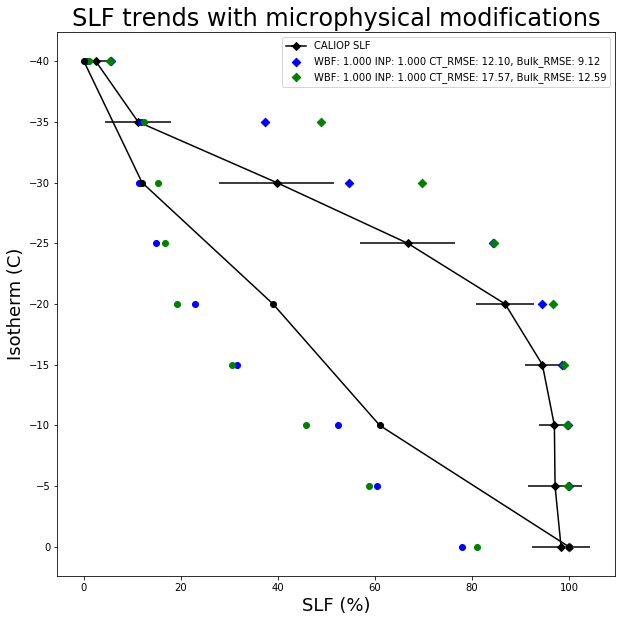

In [5]:
plt1 = origin_metric.plot_isos_all()

In [14]:
org = origin_metric.get_origin()
org.case_da

<xarray.Dataset>
Dimensions:           (isotherms_mpc: 9, lat: 96, lon: 144, time: 1)
Coordinates:
  * isotherms_mpc     (isotherms_mpc) float64 233.1 238.1 243.1 ... 268.1 273.1
  * lat               (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time              (time) datetime64[ns] 2001-02-01
  * lon               (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    cell_weight       (lat, lon) float64 4.746e-07 4.746e-07 ... 4.746e-07
    gw                (lat) float64 0.0001367 0.001093 ... 0.001093 0.0001367
    TS                (time, lat, lon) float32 240.15012 240.05244 ... 242.59334
    CT_SLF            (time, isotherms_mpc, lat, lon) float32 0.0 0.0 ... nan
    CT_SLF_ISOTM_AVG  (isotherms_mpc, lat, lon) float32 0.0 0.0 0.0 ... nan nan
    CT_SLFXCLD_ISOTM  (time, isotherms_mpc, lat, lon) float32 ...
    CT_CLD_ISOTM      (time, isotherms_mpc, lat, lon) float32 ...
    SLFXCLD_ISOTM     (time, isotherms_mpc, lat, lon) float32 ...
    CLD_ISOTM         (time, isotherms_mpc, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.3 (http://mpimet.mp...
    Conventions:       CF-1.0
    history:           Fri Jan 10 09:42:31 2020: cdo -f nc2 mergetime 2020010...
    source:            CAM
    case:              20200109_1541_wbf_1.0_inp_1.0
    logname:           jonahks
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    CDO:               Climate Data Operators version 1.9.3 (http://mpimet.mp...

Frozen({'cell_weight': <xarray.Variable (lat: 96, lon: 144)>
array([[4.74635443e-07, 4.74635443e-07, 4.74635443e-07, ...,
        4.74635443e-07, 4.74635443e-07, 4.74635443e-07],
       [3.79630501e-06, 3.79630501e-06, 3.79630501e-06, ...,
        3.79630501e-06, 3.79630501e-06, 3.79630501e-06],
       [7.58845883e-06, 7.58845883e-06, 7.58845883e-06, ...,
        7.58845883e-06, 7.58845883e-06, 7.58845883e-06],
       ...,
       [7.58845883e-06, 7.58845883e-06, 7.58845883e-06, ...,
        7.58845883e-06, 7.58845883e-06, 7.58845883e-06],
       [3.79630501e-06, 3.79630501e-06, 3.79630501e-06, ...,
        3.79630501e-06, 3.79630501e-06, 3.79630501e-06],
       [4.74635443e-07, 4.74635443e-07, 4.74635443e-07, ...,
        4.74635443e-07, 4.74635443e-07, 4.74635443e-07]]), 'gw': <xarray.Variable (lat: 96)>
array([0.000137, 0.001093, 0.002185, 0.003275, 0.004361, 0.005443, 0.006518,
       0.007587, 0.008647, 0.009697, 0.010737, 0.011765, 0.012781, 0.013782,
       0.014768, 0.015739, 0.

KeyError: 'AREI'

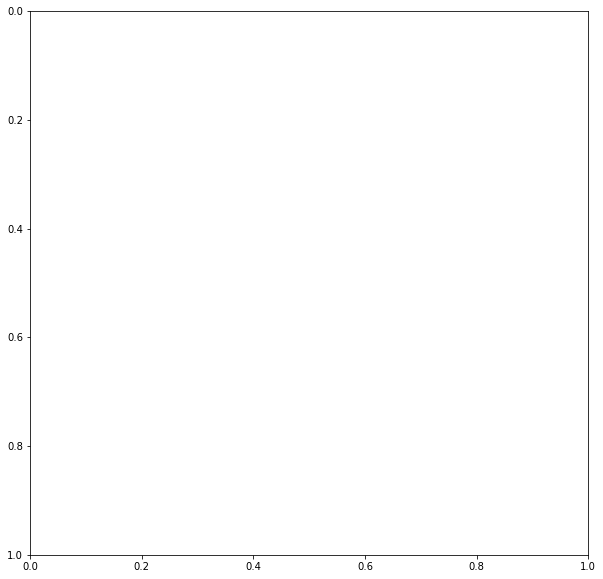

In [12]:
var_test = origin_metric.plot_single_var('AREI')

In [61]:
century_metric = CT_SLF_Metric(case_dir, sel_month=2)

base_case = '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100'
comparison_dir = "inp_validation/"
comparison_runname = "20200131_120716_singleparam_nimaxmod_wbf_1_inp_100"

#old100x = '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100'
century_metric.add_case(base_case)
century_metric.add_case(comparison_runname, path=comparison_dir)

#single_metric.add_case(old100x)
century_metric.set_origin(base_case)

mnth15runs/20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100/20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100_slfvars.nc
inp_validation/20200131_120716_singleparam_nimaxmod_wbf_1_inp_100/20200131_120716_singleparam_nimaxmod_wbf_1_inp_100_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


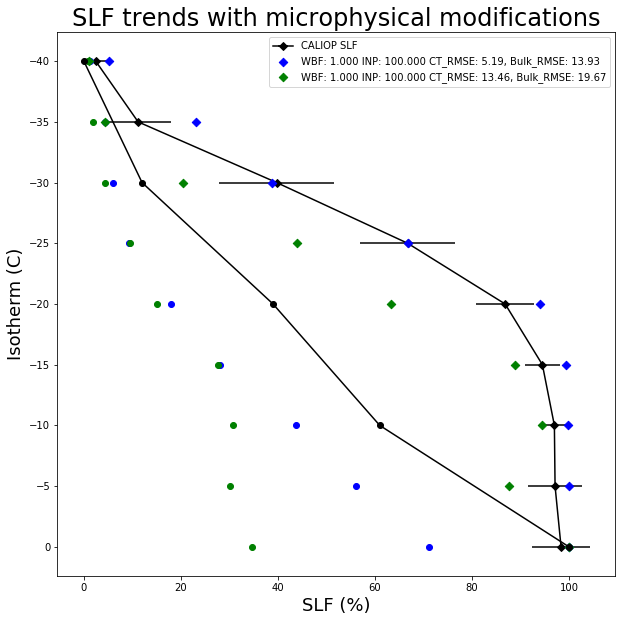

In [62]:
plt2 = century_metric.plot_isos_all()

### Specify comparison here (below)

In [53]:
comparison_dir = "inp_validation/"
comparison_runname = "20200131_120716_singleparam_nimaxmod_wbf_1_inp_100"
comparison_runname2 = "20200131_120822_singleparam_nimaxmod_wbf_1_inp_1"

In [54]:
single_metric.add_case(comparison_runname, path=comparison_dir)
single_metric.add_case(comparison_runname2, path=comparison_dir)

inp_validation/20200131_120716_singleparam_nimaxmod_wbf_1_inp_100/20200131_120716_singleparam_nimaxmod_wbf_1_inp_100_slfvars.nc
inp_validation/20200131_120822_singleparam_nimaxmod_wbf_1_inp_1/20200131_120822_singleparam_nimaxmod_wbf_1_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


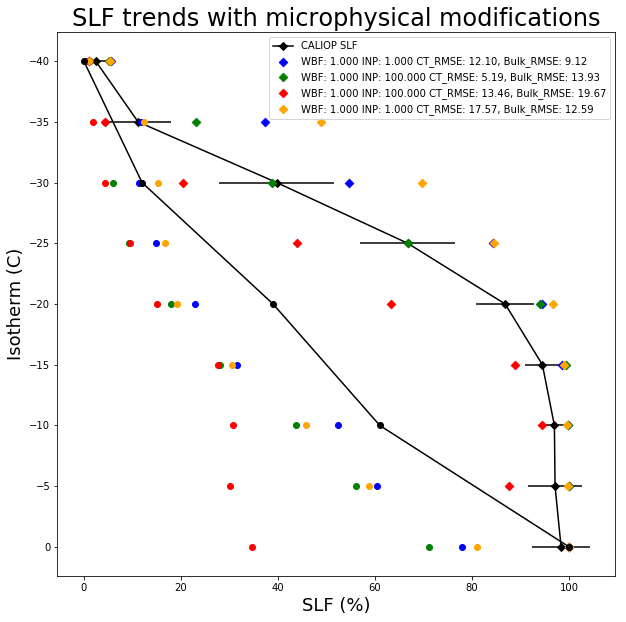

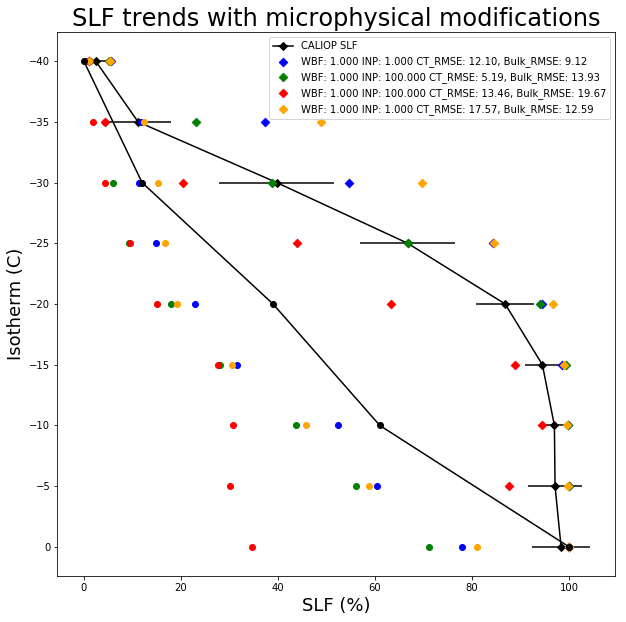

In [55]:
single_metric.plot_isos_all()

### Specify comparison here (below)

In [4]:
comparison_dir = "inp_validation/"
comparison_runname = "20200131_120716_singleparam_nimaxmod_wbf_1_inp_100"

Check available time range.

In [7]:
mnthfiles = os.listdir("%s/%s/atm/hist" % (comparison_dir, comparison_runname))

if len(mnthfiles) > 1:
    print("loading multiple months")
    # add a NCO'd combo
    
else:
    print("loading one month")

control_metric.add_case(base_case)
control_metric.set_origin(base_case)
    # just add the first month

['20200131_120716_singleparam_nimaxmod_wbf_1_inp_100.cam.h0.2000-01.nc']

In [8]:
ds = xr.open_mfdataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (comparison_dir, comparison_runname, comparison_runname), combine='by_coords')


In [12]:
ds['time']

<xarray.DataArray 'time' (time: 1)>
array(['2000-02-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01
Attributes:
    long_name:  time
    bounds:     time_bnds